<a href="https://colab.research.google.com/github/WilliamZhang20/AI-Moonlander/blob/master/DDPG_Moonlander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get install -y build-essential swig libopenmpi-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
libopenmpi-dev is already the newest version (4.1.2-2ubuntu1).
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 35 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (749 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Di

In [2]:
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 59.9 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2351188 sha256=b693d3c65554edca244f9d79196caa0cd958b512b8c87d9fe2d64b2715099598
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from copy import deepcopy

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [4]:
class Actor(nn.Module):
    """Enhanced Actor network with layer normalization"""
    def __init__(self, state_dim, action_dim, max_action, hidden_dim=256):
        super().__init__()
        self.max_action = max_action

        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.ln3 = nn.LayerNorm(hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, action_dim)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        for layer in [self.fc1, self.fc2, self.fc3]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.constant_(layer.bias, 0)
        # Final layer with smaller weights
        nn.init.uniform_(self.fc4.weight, -3e-3, 3e-3)
        nn.init.constant_(self.fc4.bias, 0)

    def forward(self, state):
        x = F.relu(self.ln1(self.fc1(state)))
        x = F.relu(self.ln2(self.fc2(x)))
        x = F.relu(self.ln3(self.fc3(x)))
        x = torch.tanh(self.fc4(x))
        return x * self.max_action

class Critic(nn.Module):
    """Enhanced Critic network with layer normalization"""
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super().__init__()

        # State processing layers
        self.state_fc1 = nn.Linear(state_dim, hidden_dim)
        self.state_ln1 = nn.LayerNorm(hidden_dim)

        # Combined state-action processing
        self.fc2 = nn.Linear(hidden_dim + action_dim, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.ln3 = nn.LayerNorm(hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        for layer in [self.state_fc1, self.fc2, self.fc3]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.constant_(layer.bias, 0)
        # Final layer with smaller weights
        nn.init.uniform_(self.fc4.weight, -3e-3, 3e-3)
        nn.init.constant_(self.fc4.bias, 0)

    def forward(self, state, action):
        # Process state
        x_state = F.relu(self.state_ln1(self.state_fc1(state)))

        # Combine state and action
        x = torch.cat([x_state, action], dim=1)
        x = F.relu(self.ln2(self.fc2(x)))
        x = F.relu(self.ln3(self.fc3(x)))
        return self.fc4(x)

In [5]:
class OrnsteinUhlenbeckNoise:
    """Ornstein-Uhlenbeck process for action noise"""
    def __init__(self, size, mu=0.0, theta=0.15, sigma=0.2):
        self.size = size
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.size) * self.mu

    def reset(self):
        self.state = np.ones(self.size) * self.mu

    def sample(self):
        dx = self.theta * (self.mu - self.state) + self.sigma * np.random.randn(self.size)
        self.state += dx
        return self.state

In [6]:
class ReplayBuffer:
    """Experience replay buffer with efficient sampling"""
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

In [7]:
class DDPG:
    """Advanced DDPG agent with modern improvements"""
    def __init__(self, state_dim, action_dim, max_action, lr_actor=1e-4, lr_critic=1e-3):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        # Networks
        self.actor = Actor(state_dim, action_dim, max_action).to(self.device)
        self.actor_target = deepcopy(self.actor)
        self.critic = Critic(state_dim, action_dim).to(self.device)
        self.critic_target = deepcopy(self.critic)

        # Optimizers with weight decay
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor, weight_decay=1e-5)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic, weight_decay=1e-4)

        # Hyperparameters
        self.tau = 0.005  # Soft update rate
        self.gamma = 0.99  # Discount factor
        self.batch_size = 128

        # Noise
        self.noise = OrnsteinUhlenbeckNoise(action_dim, sigma=0.2)
        self.noise_scale = 1.0
        self.noise_decay = 0.9995
        self.min_noise_scale = 0.1

        # Replay buffer
        self.replay_buffer = ReplayBuffer(1000000)

        # Learning rate schedulers
        self.actor_scheduler = optim.lr_scheduler.StepLR(self.actor_optimizer, step_size=10000, gamma=0.9)
        self.critic_scheduler = optim.lr_scheduler.StepLR(self.critic_optimizer, step_size=10000, gamma=0.9)

    def select_action(self, state, add_noise=True):
        state = torch.FloatTensor(state.reshape(1, -1)).to(self.device)
        action = self.actor(state).cpu().data.numpy().flatten()

        if add_noise:
            noise = self.noise.sample() * self.noise_scale
            action = np.clip(action + noise, -1, 1)

        return action

    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        # Sample batch
        state, action, reward, next_state, done = self.replay_buffer.sample(self.batch_size)

        state = torch.FloatTensor(state).to(self.device)
        action = torch.FloatTensor(action).to(self.device)
        reward = torch.FloatTensor(reward).reshape(-1, 1).to(self.device)
        next_state = torch.FloatTensor(next_state).to(self.device)
        done = torch.FloatTensor(done).reshape(-1, 1).to(self.device)

        # Critic update
        with torch.no_grad():
            next_action = self.actor_target(next_state)
            target_q = self.critic_target(next_state, next_action)
            target_q = reward + (1 - done) * self.gamma * target_q

        current_q = self.critic(state, action)
        critic_loss = F.mse_loss(current_q, target_q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 1.0)
        self.critic_optimizer.step()

        # Actor update (less frequent for stability)
        if len(self.replay_buffer) % 2 == 0:
            actor_loss = -self.critic(state, self.actor(state)).mean()

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 1.0)
            self.actor_optimizer.step()

        # Soft update target networks
        self.soft_update()

        # Update learning rates
        self.actor_scheduler.step()
        self.critic_scheduler.step()

        # Decay noise
        self.noise_scale = max(self.min_noise_scale, self.noise_scale * self.noise_decay)

    def soft_update(self):
        """Soft update target networks"""
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def save(self, filename):
        torch.save({
            'actor': self.actor.state_dict(),
            'critic': self.critic.state_dict(),
            'actor_optimizer': self.actor_optimizer.state_dict(),
            'critic_optimizer': self.critic_optimizer.state_dict(),
        }, filename)

    def load(self, filename):
        checkpoint = torch.load(filename, map_location=self.device)
        self.actor.load_state_dict(checkpoint['actor'])
        self.critic.load_state_dict(checkpoint['critic'])
        self.actor_optimizer.load_state_dict(checkpoint['actor_optimizer'])
        self.critic_optimizer.load_state_dict(checkpoint['critic_optimizer'])

Using device: cuda
Starting DDPG training...
State dim: 8, Action dim: 2, Max action: 1.0
Episode 0, Train Reward: -167.00, Eval Reward: -147.05, Noise Scale: 1.000
New best model saved! Reward: -147.05
Episode 50, Train Reward: -136.27, Eval Reward: -61.63, Noise Scale: 0.100
New best model saved! Reward: -61.63
Episode 100, Train Reward: -4.30, Eval Reward: -48.37, Noise Scale: 0.100
New best model saved! Reward: -48.37
Episode 150, Train Reward: -58.11, Eval Reward: 10.17, Noise Scale: 0.100
New best model saved! Reward: 10.17
Episode 200, Train Reward: 107.30, Eval Reward: 134.29, Noise Scale: 0.100
New best model saved! Reward: 134.29
Episode 250, Train Reward: 246.55, Eval Reward: 152.37, Noise Scale: 0.100
New best model saved! Reward: 152.37
Episode 300, Train Reward: 265.08, Eval Reward: 213.94, Noise Scale: 0.100
New best model saved! Reward: 213.94
Episode 350, Train Reward: 224.98, Eval Reward: 174.14, Noise Scale: 0.100
Episode 400, Train Reward: 188.71, Eval Reward: 235.5

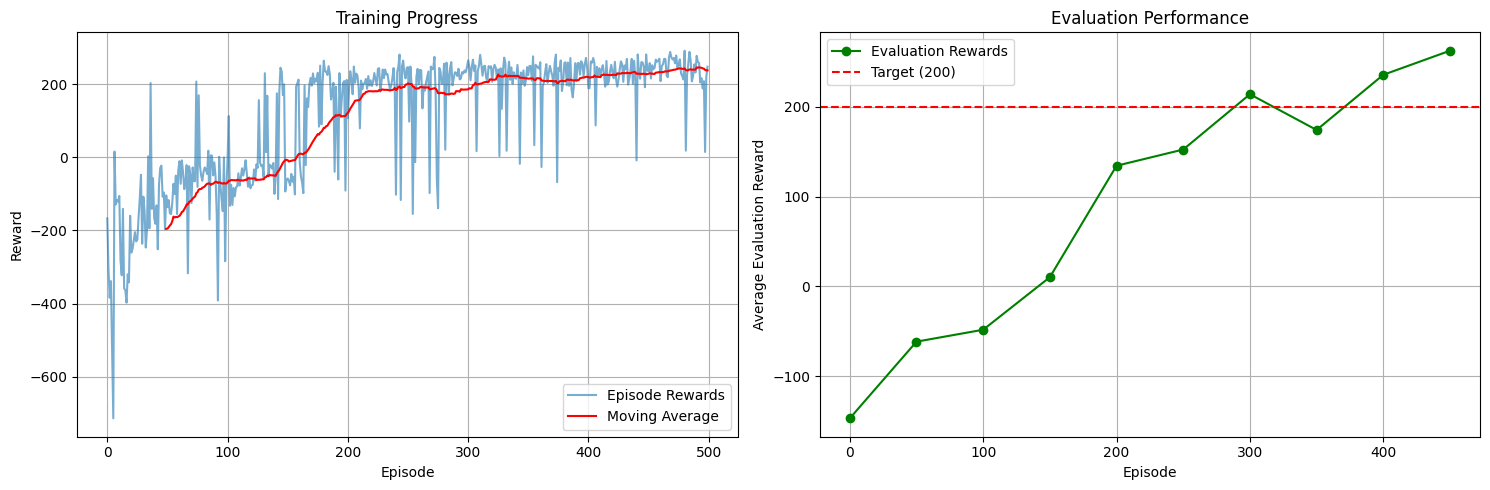


Testing trained agent...
Using device: cuda
Test Episode 1: Reward = 241.08
Test Episode 2: Reward = 291.17
Test Episode 3: Reward = 197.55
Test Episode 4: Reward = 249.70
Test Episode 5: Reward = 242.63
Test Episode 6: Reward = 246.28
Test Episode 7: Reward = 277.01
Test Episode 8: Reward = 247.10
Test Episode 9: Reward = 227.65
Test Episode 10: Reward = 215.60

Average Test Reward: 243.58


In [8]:
def train_ddpg():
    """Training function with enhanced features"""
    env = gym.make('LunarLander-v3', continuous=True)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    agent = DDPG(state_dim, action_dim, max_action)

    # Training parameters
    max_episodes = 500
    max_timesteps = 1000
    eval_freq = 50

    # Tracking
    episode_rewards = []
    eval_rewards = []
    best_reward = -float('inf')

    print("Starting DDPG training...")
    print(f"State dim: {state_dim}, Action dim: {action_dim}, Max action: {max_action}")

    for episode in range(max_episodes):
        state, _ = env.reset()
        agent.noise.reset()
        episode_reward = 0

        for t in range(max_timesteps):
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Store transition
            agent.replay_buffer.push(state, action, reward, next_state, float(done))

            # Update agent
            agent.update()

            state = next_state
            episode_reward += reward

            if done:
                break

        episode_rewards.append(episode_reward)

        # Evaluation
        if episode % eval_freq == 0:
            eval_reward = evaluate_agent(agent, env, num_episodes=5)
            eval_rewards.append(eval_reward)

            print(f"Episode {episode}, Train Reward: {episode_reward:.2f}, "
                  f"Eval Reward: {eval_reward:.2f}, Noise Scale: {agent.noise_scale:.3f}")

            # Save best model
            if eval_reward > best_reward:
                best_reward = eval_reward
                agent.save('best_ddpg_lunar_lander.pth')
                print(f"New best model saved! Reward: {eval_reward:.2f}")

    env.close()

    # Plot results
    plot_results(episode_rewards, eval_rewards, eval_freq)

    return agent

def evaluate_agent(agent, env, num_episodes=5):
    """Evaluate agent performance"""
    total_reward = 0
    for _ in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            action = agent.select_action(state, add_noise=False)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward

        total_reward += episode_reward

    return total_reward / num_episodes

def plot_results(episode_rewards, eval_rewards, eval_freq):
    """Plot training results"""
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards, alpha=0.6, label='Episode Rewards')
    # Moving average
    window = 50
    if len(episode_rewards) >= window:
        moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(episode_rewards)), moving_avg, 'r-', label='Moving Average')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    eval_episodes = [i * eval_freq for i in range(len(eval_rewards))]
    plt.plot(eval_episodes, eval_rewards, 'g-o', label='Evaluation Rewards')
    plt.axhline(y=200, color='r', linestyle='--', label='Target (200)')
    plt.xlabel('Episode')
    plt.ylabel('Average Evaluation Reward')
    plt.title('Evaluation Performance')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def test_trained_agent(model_path='best_ddpg_lunar_lander.pth', render=True):
    """Test the trained agent"""
    env = gym.make('LunarLander-v3', continuous=True, render_mode='human' if render else None)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    agent = DDPG(state_dim, action_dim, max_action)
    agent.load(model_path)

    num_test_episodes = 10
    total_reward = 0

    for episode in range(num_test_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            action = agent.select_action(state, add_noise=False)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward

        total_reward += episode_reward
        print(f"Test Episode {episode + 1}: Reward = {episode_reward:.2f}")

    avg_reward = total_reward / num_test_episodes
    print(f"\nAverage Test Reward: {avg_reward:.2f}")

    env.close()
    return avg_reward

if __name__ == "__main__":
    # Train the agent
    trained_agent = train_ddpg()

    # Test the trained agent
    print("\nTesting trained agent...")
    test_trained_agent(render=True)  # Set to True to see the landing

In [9]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import torch
import os

def record_agent_video(model_path='best_ddpg_lunar_lander.pth',
                      video_folder='./videos/',
                      num_episodes=5,
                      video_length=0):  # 0 means record all episodes
    """
    Record video of the trained DDPG agent playing LunarLander

    Args:
        model_path: Path to saved model
        video_folder: Folder to save videos
        num_episodes: Number of episodes to record
        video_length: Max steps per episode (0 = unlimited)
    """

    # Create video directory
    os.makedirs(video_folder, exist_ok=True)

    # Create environment with video recording
    env = gym.make('LunarLander-v3', continuous=True, render_mode='rgb_array')
    env = RecordVideo(
        env,
        video_folder=video_folder,
        episode_trigger=lambda x: True,  # Record all episodes
        video_length=video_length
    )

    # Load the trained agent
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    agent = DDPG(state_dim, action_dim, max_action)
    agent.load(model_path)

    print(f"Recording {num_episodes} episodes...")

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        step = 0

        while True:
            # Get action from trained agent (no noise)
            action = agent.select_action(state, add_noise=False)

            # Take step
            state, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            step += 1

            if terminated or truncated:
                break

        print(f"Episode {episode + 1}: Reward = {episode_reward:.2f}, Steps = {step}")

    env.close()
    print(f"\nVideos saved to: {video_folder}")
    print("Look for .mp4 files in the videos folder!")

# Simple version - just call this function
if __name__ == "__main__":
    record_agent_video()

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Using device: cuda
Recording 5 episodes...
Episode 1: Reward = 192.05, Steps = 405
Episode 2: Reward = 255.06, Steps = 296
Episode 3: Reward = 272.81, Steps = 270
Episode 4: Reward = 243.57, Steps = 308
Episode 5: Reward = 243.76, Steps = 326

Videos saved to: ./videos/
Look for .mp4 files in the videos folder!
